# Count Arrays for Sharma et al. 2019

This notebook is a short pipeline that creates a list of count vectors that show the number of reads recorded for each gene at each codon position.

### Step 1:
Activate the Plastid conda environment and open up a Jupyter Lab session (alternatively, a python file can be run in this conda environment)

### Step 2: 
Load in all of the necessary packages from Plastid

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Import necessary packages
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from plastid.plotting.plots import *
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
import copy
import seaborn as sns

In [3]:
# Define the path to important files
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/mmus/"
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts_codon_resolution/mmus/"
p_site_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/p-site_offsets/mmus/"
mutation = 'control'
samp_num = '1'

### Step 3
Load in your P-site offset files using the \verb|read_csv()| function from pandas

In [4]:
# Load in the table of P-site offsets. 
p_offsets=pd.read_csv(p_site_path + mutation + "_RPF_" + samp_num + "_Aligned.toTranscriptome.out_p-site-offsets", 
                      sep="\t")

### Step 4
Load in a GTF genome annotation file into python using Plastid's GTF2_TranscriptAssembler() function. This function will load in the transcripts as an iterator of transcript type objects which we will convert to a list. In most cases, we will then want to filter this list so that only the protein coding genes transcripts are present. In the event that only protein coding genes are present in the GTF file this step should be skipped. 

In [5]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + "mm10.refGene.gtf"),return_type=Transcript))

### Step 5
item Load in the Bam file containing the Ribosome Profiling data as a Bam Genome Array using Plastid's BamGenomeArray() function. While loading in these bam files, map the read alignments to their corresponding P-sites. Plastid does not have a pre-built function that can assign P-site offsets from the 3' end for varying read lengths. Therefore, In order to apply the per read length P-site offsets we calculated using riboWaltz, it is necessary to create our own python function called \verb|VariableThreePrimeMapFactory| based on the inner workings of the VariableFivePrimeMapFactory function that comes prepackaged with Plastid. You can find an example of this function in the keegan_analysis_tools.py file on the GitHub page.

In [6]:
# Read in the alignments from a BAM file and then have it map to the p-site 
alignments = BAMGenomeArray(data_path + mutation + "_RPF_" + samp_num + "_Aligned.sortedByCoord.out.bam")
alignments.set_mapping(kat.VariableThreePrimeMapFactory(p_offsets=p_offsets))

### Step 6
For each \verb|transcript| object in our list we are going to use plastids \verb|get_counts()| method to to create a numpy array that contains the number of counts at each position in the transcript. 

In [7]:
# create a list to hold the vectors
count_vectors = []

# get counts for each transcript
for transcript in transcripts:
    count_vectors.append(transcript.get_counts(alignments))

### Step 7
Once we have created our count arrays we are going to want to convert them from nucleotide resolution to codon resolution for some of the modelling we are going to do later. This can be done easily by calculating the sum of the counts every three positions using numpy's \verb|add.reduceat()| function.

In [8]:
# Calculate the loacation of the start and end of the coding region for each transcript. 
cds_starts = []
cds_ends = []

for transcript in transcripts:
    cds_starts.append(transcript.cds_start)
    cds_ends.append(transcript.cds_end)

In [9]:
# Create a list of lists containing the counts at each position of the transcript cds regions.
cds_counts_list = []

for i in range(len(count_vectors)):
    x = list(count_vectors[i][cds_starts[i]:cds_ends[i]])
    cds_counts_list.append(x)

In [10]:
# Convert the count lists from nucleotide resolution to codon resolution
codon_counts = []

for i in cds_counts_list:
    codon_counts.append(np.add.reduceat(i, np.arange(0, len(i),3)))

In [11]:
# Convert the unscaled elongation rates to a list so they can be more easily saved
for count, i in zip(codon_counts, list(range(len(codon_counts)))):
    codon_counts[i] = count.tolist()

### Step 8
save the count arrays to be used in future notebooks. You may find it helpful to use the save_count_positions() function from keegan_analysis_tools.py so that the count arrays are saved with their gene name and transcript ids. 

In [12]:
kat.save_count_positions(transcripts, codon_counts, save_path, mutation + "_" + samp_num + '_counts.csv')

## Analyzing the data files

In [13]:
#Get the transcript and vector for the gene of interest
my_transcript, my_vector = kat.find_tran_mmus('Syn1', transcripts, count_vectors)

42250
42251


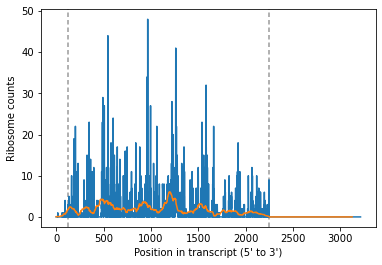

In [14]:
# 30-codon sliding window average
window = np.ones(90).astype(float)/90.0
sliding_window_avg = np.convolve(my_vector,window,mode="valid")


# plot
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(my_vector,label="%s counts" % my_transcript.get_name())
plt.plot(sliding_window_avg,label="30 codon average")
plt.xlabel("Position in transcript (5' to 3')")
plt.ylabel("Ribosome counts")

# add outlines at start & stop codons
plt.axvline(my_transcript.cds_start,color="#999999",dashes=[3,2],zorder=-1)
plt.axvline(my_transcript.cds_end,color="#999999",dashes=[3,2],zorder=-1)